In [12]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyro_ppl-1.8.1-py3-none-any.whl (718 kB)
     |████████████████████████████████| 15.7 MB 335 kB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)
     |████████████████████████████████| 65 kB 3.9 MB/s 


In [13]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached extinction-0.4.6-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (418 kB)


In [14]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached corner-2.2.1-py3-none-any.whl (15 kB)
     |████████████████████████████████| 11.2 MB 5.3 MB/s 
     |████████████████████████████████| 98 kB 7.6 MB/s 
     |████████████████████████████████| 40 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 247 kB 54.1 MB/s 
     |████████████████████████████████| 930 kB 36.3 MB/s 
     |████████████████████████████████| 3.1 MB 24.6 MB/s 


In [15]:
%%capture
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors

import corner
import time as measure_time

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

##Get constants from files

In [16]:
W0 = np.loadtxt("W0.txt")
W1 = np.loadtxt("W1.txt")
time_knots = np.loadtxt("tau_knots.txt")
wavelength_knots = np.loadtxt("l_knots.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon.txt")
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA.txt")

In [17]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

In [18]:
filename = "AT2016aj.dat"

df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
df = df.dropna()
df.head()

,MJD,FLT,FLUXCAL,FLUXCALERR,MAG,MAGERR
0,57439.23445,g,4005.553,227.047,18.493,0.061
1,57444.23967,g,4352.048,146.663,18.403,0.036
2,57449.23437,g,3297.302,142.817,18.705,0.047
3,57457.23616,g,1835.407,122.820,19.341,0.072
4,57464.23884,g,1048.120,213.621,19.949,0.220


In [163]:
tmax = 57464.23 if filename=="ASASSN-16cs.dat" else 57442.92
z_helio = 0.01802 if filename=="ASASSN-16cs.dat" else 0.06741

g_time = (df.MJD[df.FLT=='g'] - tmax) / (1 + z_helio)
r_time = (df.MJD[df.FLT=='r'] - tmax) / (1 + z_helio)
i_time = (df.MJD[df.FLT=='i'] - tmax) / (1 + z_helio)
z_time = (df.MJD[df.FLT=='z'] - tmax) / (1 + z_helio)

g_mag = df.MAG[df.FLT=='g']
r_mag = df.MAG[df.FLT=='r']
i_mag = df.MAG[df.FLT=='i']
z_mag = df.MAG[df.FLT=='z']

g_magerr = df.MAGERR[df.FLT=='g']
r_magerr = df.MAGERR[df.FLT=='r']
i_magerr = df.MAGERR[df.FLT=='i'][:-1]
z_magerr = df.MAGERR[df.FLT=='z']

g_flux = df.FLUXCAL[df.FLT=='g']
r_flux = df.FLUXCAL[df.FLT=='r']
i_flux = df.FLUXCAL[df.FLT=='i']
z_flux = df.FLUXCAL[df.FLT=='z']

g_fluxerr = df.FLUXCALERR[df.FLT=='g']
r_fluxerr = df.FLUXCALERR[df.FLT=='r']
i_fluxerr = df.FLUXCALERR[df.FLT=='i']
z_fluxerr = df.FLUXCALERR[df.FLT=='z']

# i_mag = i_mag[:-1]
# i_time = i_time[:-1] ## remove last point which is outside the (-10, 40) time range

# i_flux = i_flux[:-1]

In [20]:
z_flux

18    2641.760
19    1720.968
20    1640.421
21    1150.321
22    1282.191
Name: FLUXCAL, dtype: float64

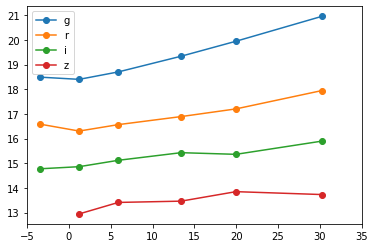

In [21]:
plt.plot(g_time, g_mag, label='g', marker='o')
plt.plot(r_time, r_mag-2, label = 'r', marker='o')
plt.plot(i_time, i_mag-4,label = 'i', marker='o')
plt.plot(z_time, z_mag-6, label = 'z', marker='o')
plt.legend()
# plt.ylim(19,10)
plt.xlim(-5, 35)
plt.show() 

In [268]:
# cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
# z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
# mu_s = cosmo.distmod(z).value

z = 0.018
# mu_s = 31.

z_helio = 0.06741 ## for AT2016aj
EBV_MW = 0.0414 ## for AT2016aj

z = z_helio

ZPT = 27.5
M0 = -19.5
gamma = np.log(10) / 2.5

# EBV_MW = 0.1
Av_obs = EBV_MW * 3.1

In [269]:
hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

Things we can pre-calculate
---



In [270]:
def get_lambda_int_for_band(band_wavelengths, z = z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 150)

In [271]:
# times_to_interpolate = np.linspace(-10, 40)
times_to_interpolate = i_time.values
wavelengths_to_interpolate = get_lambda_int_for_band(i_wavelengths)

In [272]:
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))

In [273]:
xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
xis_matrix.shape

(150, 6)

In [274]:
## interpolate Hsiao coefficient at desired time and wavelength points
S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
for i, wavelength in enumerate(wavelengths_to_interpolate):
  for j, time in enumerate(times_to_interpolate):
    S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

In [275]:
throughput_interpolator = interp1d(i_wavelengths, i_norm_throughput)
b = throughput_interpolator(wavelengths_to_interpolate * (1 + z))

xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)
h.shape

(150,)

Now let's actually make the model
---

In [276]:
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

In [277]:
def get_flux_from_params(epsilon_interior, theta, mu_s, dMs, Av, W0 = W0, W1 = W1, xis_matrix = xis_matrix, S0 = S0, h = h, Jl = Jl, Jt = Jt):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  Stilde = S0 * np.exp(-gamma * (JlWJt + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [278]:
tauA

0.252

In [279]:
pyro.sample("Av", dist.Exponential(tauA))

tensor(7.5113)

In [280]:
# def model_vi():
#   epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))
#   theta = pyro.sample("theta", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
#   mu_s = pyro.sample("mu_s", dist.Normal(34.5, 1.)) ## fix this later


#   # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
#   dMs = torch.tensor(0.)
#   # Av = pyro.sample("Av", dist.Exponential(tauA))
#   Av = pyro.sample("Av", dist.Normal(0.27, 1.))

#   epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
#   epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

#   W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

#   JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

#   Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

#   f = 10**(0.4 * ZPT - mu_s - M0 - dMs) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))

#   with pyro.plate("observations", len(i_flux.values)):
#     pyro.sample("flux", dist.Normal(f, 200. * torch.ones(6)).independent(1), obs = torch.as_tensor(i_flux.values))

In [281]:
Av_obs

0.12834

In [282]:
# times_to_interpolate = times

wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}
times_dict = {'g':g_time.values, 'r':r_time.values, 'i':i_time.values, 'z':z_time.values}

bands = ['g', 'r', 'i', 'z']

band_Jl = {}
band_xis_matrix = {}
band_S0 = {}
band_h = {}
band_Jt = {}

for band in bands:
  band_wavelengths = wavelengths_dict[band]
  band_norm_throughput = norm_throughput_dict[band]

  times_to_interpolate = times_dict[band]

  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
  band_Jt[band] = Jt

  wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
  
  Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
  band_Jl[band] = Jl
  xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
  xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
  band_xis_matrix[band] = xis_matrix

  S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
  for i, wavelength in enumerate(wavelengths_to_interpolate):
    for j, time_point in enumerate(times_to_interpolate):
      S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

  band_S0[band] = S0

  throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
  b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

  xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
  dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
  h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

  band_h[band] = h

#   band_flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), 
#                               torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av),
#                               xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
  
#   all_band_fluxes.append(band_flux)

# all_band_fluxes = np.array(all_band_fluxes)

In [283]:
flux_errors = [(torch.as_tensor(g_fluxerr.values), torch.as_tensor(r_fluxerr.values), torch.as_tensor(i_fluxerr.values), torch.as_tensor(z_fluxerr.values))]

In [284]:
def model_vi(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)
  
  if obs is not None:
    # for i in range(len(bands)):
    for i in pyro.plate("bands", len(bands)):
      # print(i)
      with pyro.plate("observations" + str(bands[i])):
        # print(len(generated_fluxes[i]))
        # for j in range(len(generated_fluxes[i])):
          pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[0][i]), obs = obs[0][i])
          # print(obs[0][i][j])
        # print(generated_fluxes[i])

In [285]:
observed_fluxes = [(torch.as_tensor(g_flux.values), torch.as_tensor(r_flux.values), torch.as_tensor(i_flux.values), torch.as_tensor(z_flux.values))]

In [286]:
observed_fluxes

[(tensor([4005.5530, 4352.0480, 3297.3020, 1835.4070, 1048.1200,  412.0150],
         dtype=torch.float64),
  tensor([3676.0450, 4759.6250, 3742.9230, 2771.0850, 2079.0390, 1046.1990],
         dtype=torch.float64),
  tensor([3090.3530, 2855.2300, 2249.6650, 1691.2290, 1799.4850, 1096.8880],
         dtype=torch.float64),
  tensor([2641.7600, 1720.9680, 1640.4210, 1150.3210, 1282.1910],
         dtype=torch.float64))]

In [287]:
flux_errors

[(tensor([227.0470, 146.6630, 142.8170, 122.8200, 213.6210, 102.0220],
         dtype=torch.float64),
  tensor([165.0210, 142.7150, 142.8040, 126.0320, 152.1720,  97.9100],
         dtype=torch.float64),
  tensor([160.9570, 136.3000, 173.2550, 117.7470, 152.3770, 105.5380],
         dtype=torch.float64),
  tensor([204.7040, 236.1660, 173.7900, 231.6740, 157.4260], dtype=torch.float64))]

In [288]:
observed_fluxes

[(tensor([4005.5530, 4352.0480, 3297.3020, 1835.4070, 1048.1200,  412.0150],
         dtype=torch.float64),
  tensor([3676.0450, 4759.6250, 3742.9230, 2771.0850, 2079.0390, 1046.1990],
         dtype=torch.float64),
  tensor([3090.3530, 2855.2300, 2249.6650, 1691.2290, 1799.4850, 1096.8880],
         dtype=torch.float64),
  tensor([2641.7600, 1720.9680, 1640.4210, 1150.3210, 1282.1910],
         dtype=torch.float64))]

In [289]:
other_tensor = torch.as_tensor(np.array([[52404.7879, 58130.4852, 46895.5337, 29594.8725, 17534.0982, 11053.1069],
        [48598.4592, 57606.4501, 51917.4832, 38853.5554, 30378.8843, 24328.2872],
        [40029.6385, 34592.7530, 29652.9017, 23438.5865, 22959.2071, 21189.7540],
        [30952.7222, 34969.4993, 35130.8207, 31905.8129, 28952.3929, 26269.5857]]))

In [290]:
len(other_tensor[0])

6

In [291]:
model_vi(obs = observed_fluxes)

In [292]:
EBV_MW

0.0414

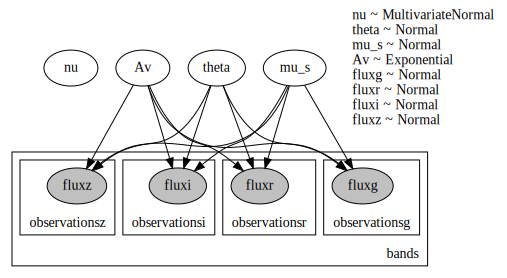

In [293]:
pyro.render_model(model_vi, model_args = (observed_fluxes,), render_distributions=True, render_params = True)

In [294]:
autoguide_vi = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_loc_fn = pyro.infer.autoguide.initialization.init_to_sample(), init_scale = 1.)

In [295]:
pyro.get_param_store().clear()
adam = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)}, {"clip_norm": 10.0})
# adam = pyro.optim.SGD({"lr": 0.1})


svi = SVI(model_vi, autoguide_vi, adam, loss=Trace_ELBO().differentiable_loss)
# svi = SVI(model_vi, custom_guide, adam, loss=Trace_ELBO().differentiable_loss)

for i in range(10):
  svi.step(observed_fluxes)

In [296]:
def train(model, guide, lr=0.01, n_steps=5000, verbose = True):
    pyro.get_param_store().clear()
    adam_params = {"lr": lr, "betas": (0.95, 0.999)}
    # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
    adam = pyro.optim.ClippedAdam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    losses = []
    losses_every_500 = []

    for step in range(n_steps):
        loss = svi.step(observed_fluxes)
        losses.append(loss)
        if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
            losses_every_500.append(loss)
            ## if it hasn't decreased in 3 steps, end fitting
            # if step > 2000:
            #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
            #   break
    return losses

In [297]:
start_time = measure_time.time()
losses = train(model_vi, autoguide_vi, lr = 0.01, n_steps = 20000)
end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 2271690254706.6357
[iter 500]  loss: 3731.9517
[iter 1000]  loss: 2957.4548
[iter 1500]  loss: 2397.2028
[iter 2000]  loss: 912.0327
[iter 2500]  loss: 239.2216
[iter 3000]  loss: 191.8440
[iter 3500]  loss: 167.8245
[iter 4000]  loss: 165.8603
[iter 4500]  loss: 168.4292
[iter 5000]  loss: 170.4464
[iter 5500]  loss: 166.6989
[iter 6000]  loss: 170.9297
[iter 6500]  loss: 173.6898
[iter 7000]  loss: 166.0738
[iter 7500]  loss: 169.2839
[iter 8000]  loss: 168.7550
[iter 8500]  loss: 166.2865
[iter 9000]  loss: 171.5698
[iter 9500]  loss: 169.1067
[iter 10000]  loss: 167.5600
[iter 10500]  loss: 168.1562
[iter 11000]  loss: 166.9325
[iter 11500]  loss: 165.9392
[iter 12000]  loss: 166.3792
[iter 12500]  loss: 166.4750
[iter 13000]  loss: 172.4149
[iter 13500]  loss: 169.2759
[iter 14000]  loss: 165.0055
[iter 14500]  loss: 166.5867
[iter 15000]  loss: 172.7780
[iter 15500]  loss: 169.2960
[iter 16000]  loss: 171.4317
[iter 16500]  loss: 166.9026
[iter 17000]  loss: 184.2

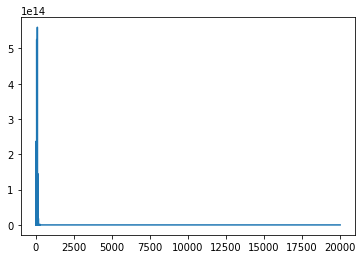

In [298]:
plt.plot(losses)

In [299]:
autoguide_vi.median()['theta']

tensor(0.5801)

In [300]:
autoguide_vi.median()['Av']

tensor(0.2484)

In [301]:
autoguide_vi.median()['mu_s']

tensor(37.2247)

In [302]:
autoguide_vi.median()['nu']

tensor([ 3.3040e-01, -1.6249e-01,  8.3142e-01,  3.2803e-01, -1.9063e-01,
         3.0155e-01,  1.0042e-01, -1.4993e-01, -3.2908e-01,  8.3571e-03,
         4.0662e-01, -4.2808e-01,  4.1202e-02, -1.0556e-03, -5.1895e-01,
         3.5914e-02,  9.2579e-02, -1.3212e-01,  2.7167e-01,  3.8480e-01,
        -3.1198e-01,  5.3605e-01,  2.3695e-01, -6.7379e-01, -1.1319e-01,
        -2.2150e-01, -2.4116e-01, -3.7772e-01, -2.5980e-02, -4.4252e-01,
        -2.7196e-01,  6.3611e-02, -4.4119e-02, -6.0608e-02, -1.2313e-01,
        -6.1990e-02,  5.5650e-02,  2.0179e-01,  2.4948e-01,  5.1700e-01,
         1.3651e-01, -2.5805e-01,  6.0829e-02,  1.3061e-01,  8.2439e-03,
         2.4830e-02, -2.1028e-02, -1.1765e-02,  3.9309e-05,  3.2897e-02,
        -2.7882e-02,  1.2630e-02,  1.1342e-02, -4.0939e-03])

In [320]:
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi)
start_time = measure_time.time()
losses = train(model_vi, autoguide_laplace, n_steps = 3000)
end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 1902.4336
[iter 500]  loss: 205.5114
[iter 1000]  loss: 203.8658
[iter 1500]  loss: 203.8506
[iter 2000]  loss: 203.8506
[iter 2500]  loss: 203.8506
Time: 28.475240468978882 seconds


In [321]:
new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes)
losses = train(model_vi, new_laplace_approx_guide, n_steps = 10000)

[iter 0]  loss: 162.6230
[iter 500]  loss: 165.7332
[iter 1000]  loss: 163.0791
[iter 1500]  loss: 162.5536
[iter 2000]  loss: 169.1056
[iter 2500]  loss: 161.0881
[iter 3000]  loss: 164.8994
[iter 3500]  loss: 162.6672
[iter 4000]  loss: 163.7414
[iter 4500]  loss: 165.9802
[iter 5000]  loss: 162.4426
[iter 5500]  loss: 162.5479
[iter 6000]  loss: 162.6297
[iter 6500]  loss: 166.5618
[iter 7000]  loss: 162.8407
[iter 7500]  loss: 166.5029
[iter 8000]  loss: 162.6049
[iter 8500]  loss: 163.5153
[iter 9000]  loss: 162.5217
[iter 9500]  loss: 162.4673


In [ ]:
posterior_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = 100)(None,)
posterior_samples['Av']

In [ ]:
def calculate_all_fluxes_from_params(nu, theta, mu_s, dMs, Av):
  times_to_interpolate = np.linspace(-10, 40)
  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

  epsilon_interior = np.matmul(L_sigma_epsilon, nu.numpy().T)

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  generated_fluxes_from_params = []

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    Jl = band_Jl[band]
    # xis_matrix = band_xis_matrix[band]
    # h = band_h[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
    
    # Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_flux = get_flux_from_params(torch.as_tensor(epsilon_interior), torch.as_tensor(theta), 
                                torch.as_tensor(mu_s), torch.as_tensor(dMs), torch.as_tensor(Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    generated_fluxes_from_params.append(band_flux)
  
  return np.array(generated_fluxes_from_params)

In [ ]:
posterior_smooth_curves = []
for nu, theta, mu_s, Av in zip(posterior_samples['nu'][:,0,0], posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  posterior_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [ ]:
posterior_smooth_curves = np.array(posterior_smooth_curves)
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)
upper_posterior_fit = np.percentile(posterior_smooth_curves, 50 + 34.1, axis = 0)
lower_posterior_fit = np.percentile(posterior_smooth_curves, 50 - 34.1, axis = 0)

In [ ]:
colors  = ['g', 'r', 'c', 'k']
# offset = np.array([0, 1000,2000,3000]) * 30
offset = np.zeros(4)
for i, band_flux in enumerate(median_posterior_fit):
    plt.plot(np.linspace(-10, 40), band_flux + offset[i], color = colors[i])
    plt.fill_between(np.linspace(-10, 40), upper_posterior_fit[i]+ offset[i], lower_posterior_fit[i]+ offset[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(observed_fluxes.numpy()):
  plt.plot(times_to_interpolate, band_flux + offset[i], 'o',color = colors[i], label = bands[i])
plt.legend()
plt.title("Posterior samples from VI")

In [304]:
num_corner_samples = 1000
vi_corner_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = num_corner_samples)(None,)

In [322]:
vi_trained_laplace_samples = Predictive(model_vi, guide = new_laplace_approx_guide, num_samples = num_corner_samples)(None,)

In [323]:
laplace_samples = Predictive(model_vi, guide = autoguide_laplace.laplace_approximation(observed_fluxes), num_samples = num_corner_samples)(None,)

In [324]:
other_fit = np.load("AT2016aj_chains_210610_135216.npy", allow_pickle = True).item()

In [325]:
other_fit.keys()

odict_keys(['lp__', 'mu', 'AV', 'theta', 'delM', 'epsilon'])

In [326]:
len(other_fit['mu'])

1000

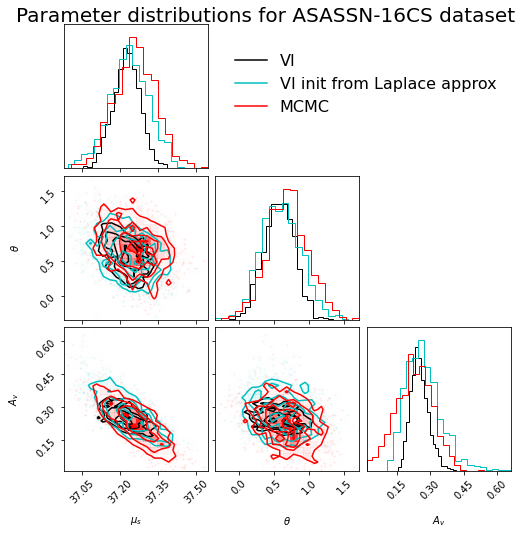

In [327]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'].numpy(),vi_corner_samples['theta'].numpy(), 
                                  vi_corner_samples['Av'].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"])
# corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
#                                   vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
corner.corner(np.vstack((laplace_samples['mu_s'].numpy(),laplace_samples['theta'].numpy(), 
                                  laplace_samples['Av'].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
corner.corner(np.vstack((other_fit['mu'] + other_fit['delM'],other_fit['theta'], other_fit['AV'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
colors = ['k','c', 'r']

labels = ['VI', 'VI init from Laplace approx', 'MCMC']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.suptitle("Parameter distributions for ASASSN-16CS dataset", fontsize = 20)
plt.show()

In [310]:
observed_fluxes

[(tensor([4005.5530, 4352.0480, 3297.3020, 1835.4070, 1048.1200,  412.0150],
         dtype=torch.float64),
  tensor([3676.0450, 4759.6250, 3742.9230, 2771.0850, 2079.0390, 1046.1990],
         dtype=torch.float64),
  tensor([3090.3530, 2855.2300, 2249.6650, 1691.2290, 1799.4850, 1096.8880],
         dtype=torch.float64),
  tensor([2641.7600, 1720.9680, 1640.4210, 1150.3210, 1282.1910],
         dtype=torch.float64))]

In [311]:
flux_errors

[(tensor([227.0470, 146.6630, 142.8170, 122.8200, 213.6210, 102.0220],
         dtype=torch.float64),
  tensor([165.0210, 142.7150, 142.8040, 126.0320, 152.1720,  97.9100],
         dtype=torch.float64),
  tensor([160.9570, 136.3000, 173.2550, 117.7470, 152.3770, 105.5380],
         dtype=torch.float64),
  tensor([204.7040, 236.1660, 173.7900, 231.6740, 157.4260], dtype=torch.float64))]

In [312]:
def model_mcmc(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.double), nu.double())
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  if obs is not None:
    # for i in range(len(bands)):
    for i in pyro.plate("bands", len(bands)):
      # print(i)
      with pyro.plate("observations"):
        # print(len(generated_fluxes[i]))
        # for j in range(len(generated_fluxes[i])):
            pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[0][i]), obs = obs[0][i])

In [314]:
num_chains = 1
nuts_kernel = pyro.infer.NUTS(model_mcmc, adapt_step_size=True)

mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=600, warmup_steps=250, num_chains = num_chains)

start_time = measure_time.time()
mcmc.run(observed_fluxes)
end_time = measure_time.time()
print("Total:", end_time - start_time, "seconds")

Sample: 100%|██████████| 850/850 [14:48,  1.04s/it, step size=1.23e-01, acc. prob=0.937]

Total: 888.1043004989624 seconds


In [315]:
mcmc_corner_samples = mcmc.get_samples(num_samples = num_corner_samples)

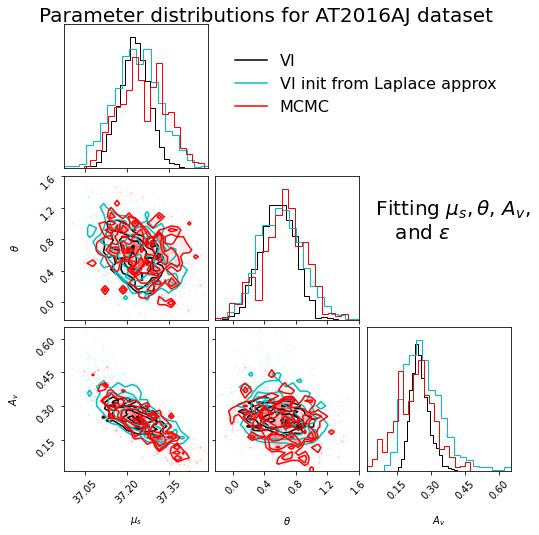

In [349]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'].numpy(),vi_corner_samples['theta'].numpy(), 
                                  vi_corner_samples['Av'].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color = 'k')
corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'].numpy(),vi_trained_laplace_samples['theta'].numpy(), 
                                  vi_trained_laplace_samples['Av'].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color ='r',fig = figure,)
# corner.corner(np.vstack((laplace_samples['mu_s'][:,0,0].numpy(),laplace_samples['theta'][:,0,0].numpy(), 
#                                   laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'b')
# corner.corner(np.vstack((other_fit['mu'] + other_fit['delM'],other_fit['theta'], other_fit['AV'])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
# colors = ['k','c', 'r']

# labels = ['VI', 'VI init from Laplace approx', 'MCMC']
colors = [ 'k', 'c', 'r']
labels = ['VI', 'VI init from Laplace approx','MCMC']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)

plt.text(0, 270, "  Fitting $\\mu_s, \\theta$, $A_v$, \n     and $\\epsilon$", fontsize = 20)
figure.suptitle("Parameter distributions for AT2016AJ dataset", fontsize = 20)
plt.show()

In [317]:
mcmc.diagnostics()

{'Av': OrderedDict([('n_eff', tensor(159.0502, dtype=torch.float64)),
              ('r_hat', tensor(1.0291, dtype=torch.float64))]),
 'acceptance rate': {'chain 0': 1.0},
 'divergences': {'chain 0': []},
 'mu_s': OrderedDict([('n_eff', tensor(106.7515, dtype=torch.float64)),
              ('r_hat', tensor(1.0494, dtype=torch.float64))]),
 'nu': OrderedDict([('n_eff',
               tensor([ 451.0539,  622.1975,  743.0407,  614.9170,  589.7426,  746.6896,
                       1230.6126, 1061.0642,  940.4999,  447.1816,  213.6518,  494.1810,
                        540.4096,  177.6918,  586.4685,  836.4641,  494.3881,  454.7005,
                        337.2809,  954.7321,  682.8388,  568.0248,  437.9903,  968.9045,
                        633.4961,  772.3142,  748.0857, 1411.1536, 1402.2228,  827.0599,
                       1547.0479,  818.6993,  960.7069,  727.4459, 1123.7566,  994.4849,
                        598.2768, 1098.7058,  360.8919,  342.0956,  516.4634,  360.6026,
      

In [ ]:
many_samples = mcmc.get_samples(num_samples = 10000)
np.savetxt("mcmc_at2016aj_samples.txt",[many_samples['mu_s'].numpy(),many_samples['theta'].numpy(),many_samples['Av'].numpy()])